In [16]:
# Requirements: numpy, pandas, matplotlib, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

1. Load data

In [17]:
data_path = '/content/xy_data.csv'
if not os.path.exists(data_path):
    raise FileNotFoundError("Please upload 'xy_data.csv' to /content (Colab) before running this cell.")

df = pd.read_csv(data_path)
N = len(df)
t = np.linspace(6, 60, N)  # crucial: uniform t from 6 to 60 with N points
x_data = df['x'].values
y_data = df['y'].values

Inspect basic properties

Shape of dataset: (1500, 2)

Summary:
                 x            y
count  1500.000000  1500.000000
mean     83.713931    58.263519
std      13.697157     7.696524
min      59.657204    46.032295
25%      72.282910    51.124211
50%      84.710995    57.681288
75%      93.368257    66.138374
max     109.231520    69.685510


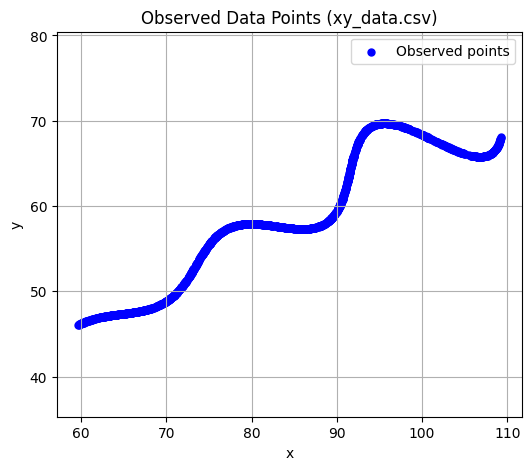

In [18]:

print("Shape of dataset:", df.shape)
print("\nSummary:")
print(df.describe())

# Plot raw points to visualize curve
plt.figure(figsize=(6,5))
plt.scatter(df["x"], df["y"], s=25, color="blue", label="Observed points")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observed Data Points (xy_data.csv)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


2. Model definition

In [19]:
def model(params, t):
    #params: [theta_deg, M, X]
    # Convert theta to radians immediately (VERY IMPORTANT).
    # Returns: x_pred, y_pred arrays for the given t.
    theta_deg, M, X = params
    theta = np.deg2rad(theta_deg)   # convert degrees -> radians
    exp_term = np.exp(M * np.abs(t))
    x_pred = (t * np.cos(theta) - exp_term * np.sin(0.3 * t) * np.sin(theta) + X)
    y_pred = (42 + t * np.sin(theta) + exp_term * np.sin(0.3 * t) * np.cos(theta))
    return x_pred, y_pred

3. L1 loss function

In [20]:
def l1_loss(params):
    x_pred, y_pred = model(params, t)
    # Sum absolute differences for x and y (per assignment)
    return np.sum(np.abs(x_data - x_pred) + np.abs(y_data - y_pred))

4. Optimization settings

In [21]:
# Bounds: theta in (0,50), M in (-0.05,0.05), X in (0,100)
bounds = [(1e-8, 50.0), (-0.05, 0.05), (0.0, 100.0)]

# Seeds: deterministic + random multi-starts
seeds = [
    [25.0, 0.0, 50.0],
    [10.0, 0.01, 20.0],
    [40.0, -0.01, 80.0],
    [5.0, 0.02, 10.0],
    [45.0, -0.02, 90.0],
    [30.0, 0.005, 60.0],
]

rng = np.random.RandomState(42)
for _ in range(20):  # add 20 random seeds
    seeds.append([rng.uniform(0,50), rng.uniform(-0.05,0.05), rng.uniform(0,100)])

best_res = None
best_fun = np.inf
results = []

5. Run optimization for each seed

In [22]:
for seed in seeds:
    res = minimize(l1_loss, x0=np.array(seed), bounds=bounds, method='L-BFGS-B',
                   options={'maxiter': 20000, 'ftol': 1e-12})
    results.append(res)
    if res.fun < best_fun:
        best_fun = res.fun
        best_res = res

# ------------- 6. Extract best solution and diagnostics -------------
theta_deg_best, M_best, X_best = best_res.x
x_pred_best, y_pred_best = model(best_res.x, t)
l1_best = l1_loss(best_res.x)
rmse = np.sqrt(np.mean((x_data - x_pred_best)**2 + (y_data - y_pred_best)**2))  # not graded, informative

print("Best-fit parameters (degrees):")
print(f"theta (degrees) = {theta_deg_best:.12f}")
print(f"M = {M_best:.12f}")
print(f"X = {X_best:.12f}")
print(f"L1 loss = {l1_best:.12f}")
print(f"RMSE (informational) = {rmse:.12f}")

print("\nTop 5 results by L1 loss:")
sorted_res = sorted(results, key=lambda r: r.fun)
for i, r in enumerate(sorted_res[:5], 1):
    th, mm, xx = r.x
    print(f"{i}) theta={th:.10f}, M={mm:.10e}, X={xx:.10f}, L1={r.fun:.8f}")

Best-fit parameters (degrees):
theta (degrees) = 28.118423074179
M = 0.021388956654
X = 54.901722855097
L1 loss = 37865.093837691806
RMSE (informational) = 22.756413927539

Top 5 results by L1 loss:
1) theta=28.1184230742, M=2.1388956654e-02, X=54.9017228551, L1=37865.09383769
2) theta=28.1184231077, M=2.1388956123e-02, X=54.9015414797, L1=37865.09383782
3) theta=28.1184225870, M=2.1388953646e-02, X=54.8983404598, L1=37865.09383831
4) theta=28.1184222651, M=2.1388952943e-02, X=54.9003089118, L1=37865.09383842
5) theta=28.1184221509, M=2.1388952627e-02, X=54.8984161894, L1=37865.09383847


 7. Save outputs (plot and predicted points)

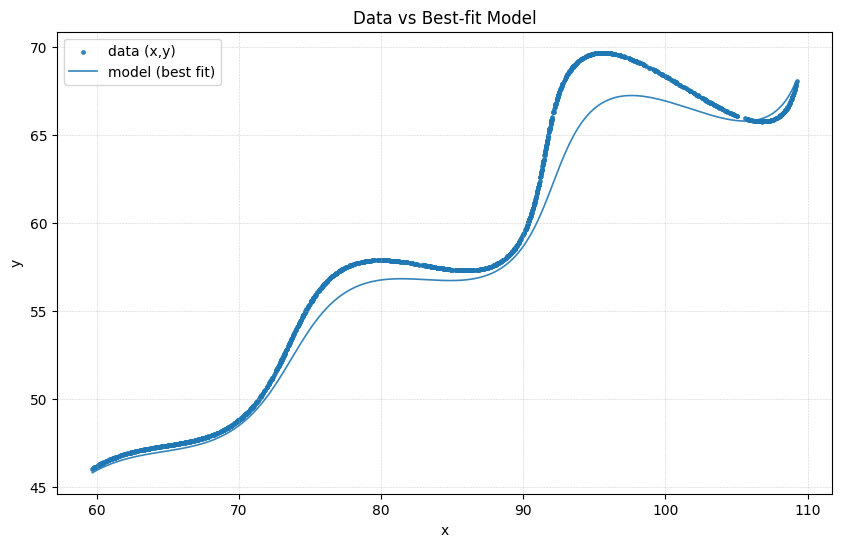


Saved predicted points CSV: /content/curve_fitter_outputs/predicted_curve.csv
Saved plot: /content/curve_fitter_outputs/fit_plot.png


In [23]:
out_dir = '/content/curve_fitter_outputs'
os.makedirs(out_dir, exist_ok=True)

# Save predicted curve as CSV
out_df = pd.DataFrame({'t': t, 'x_pred': x_pred_best, 'y_pred': y_pred_best})
out_csv = os.path.join(out_dir, 'predicted_curve.csv')
out_df.to_csv(out_csv, index=False)

# Plot: data scatter and model curve
plt.figure(figsize=(10,6))
plt.scatter(x_data, y_data, s=6, label='data (x,y)', alpha=0.85)
plt.plot(x_pred_best, y_pred_best, linewidth=1.2, label='model (best fit)', alpha=0.9)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Data vs Best-fit Model')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
plot_path = os.path.join(out_dir, 'fit_plot.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved predicted points CSV: {out_csv}")
print(f"Saved plot: {plot_path}")

 8. Print Desmos-ready expression

In [24]:
desmos = (
    f"( t*cos({theta_deg_best:.12f}°) - exp({M_best:.12f}*abs(t))*sin(0.3*t)*sin({theta_deg_best:.12f}°) + {X_best:.12f}, "
    f"42 + t*sin({theta_deg_best:.12f}°) + exp({M_best:.12f}*abs(t))*sin(0.3*t)*cos({theta_deg_best:.12f}°) )"
)
print("\nDesmos-ready parametric pair (copy to Desmos):")
print(desmos)


Desmos-ready parametric pair (copy to Desmos):
( t*cos(28.118423074179°) - exp(0.021388956654*abs(t))*sin(0.3*t)*sin(28.118423074179°) + 54.901722855097, 42 + t*sin(28.118423074179°) + exp(0.021388956654*abs(t))*sin(0.3*t)*cos(28.118423074179°) )


Attempting differential_evolution with parallel workers (workers=-1). If pickling fails, we'll retry with workers=1.

DE result:
theta (degrees) = 27.943754812405
M = 0.020636055004
X = 54.703198079069
L1 loss = 37866.543906824583
RMSE (info) = 22.753891079378

Local best (if available):
theta = 28.118423074179, M = 0.021388956654, X = 54.901722855097, L1 = 37865.093837691806
Local solution is better or equal to DE-polished result.


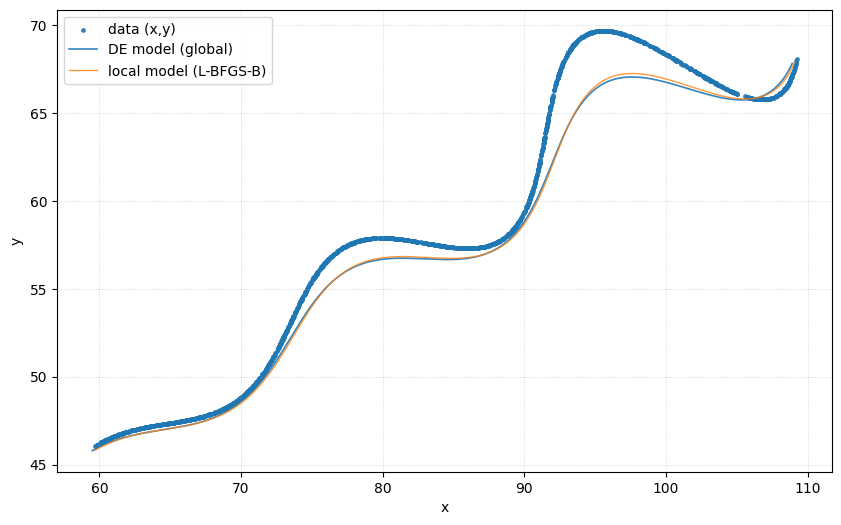


Saved DE CSV: /content/de_outputs/predicted_curve_de.csv
Saved DE plot: /content/de_outputs/fit_plot_de.png


In [25]:

from scipy.optimize import differential_evolution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import traceback

# Ensure we have bounds
bounds_de = [(0.0, 50.0), (-0.05, 0.05), (0.0, 100.0)]

# A top-level function (picklable) wrapping the l1_loss function
def objective_for_de(p):
    # p will be a numpy array of shape (3,)
    # simply forward to your l1_loss() which uses t, x_data, y_data in outer scope
    return l1_loss(p)

# DE parameters (tune these for speed/quality)
de_popsize = 20
de_maxiter = 200
de_tol = 0.01
seed = 42

print("Attempting differential_evolution with parallel workers (workers=-1). If pickling fails, we'll retry with workers=1.")

try:
    res_de = differential_evolution(
        func=objective_for_de,
        bounds=bounds_de,
        strategy='best1bin',
        maxiter=de_maxiter,
        popsize=de_popsize,
        tol=de_tol,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=seed,
        polish=True,
        updating='deferred',   # explicit; SciPy may override for parallel workers
        workers=-1             # try parallel evaluation
    )
except Exception as e:
    print("Parallel DE failed with exception (likely pickling). Falling back to single-worker DE.")
    print("Exception summary:", repr(e))
    # Optionally show full traceback for debug
    traceback.print_exc()
    # Retry with workers=1 (no pickling issue)
    res_de = differential_evolution(
        func=objective_for_de,
        bounds=bounds_de,
        strategy='best1bin',
        maxiter=de_maxiter,
        popsize=de_popsize,
        tol=de_tol,
        mutation=(0.5,1),
        recombination=0.7,
        seed=seed,
        polish=True,
        workers=1
    )

# Report & save outputs
theta_deg_de, M_de, X_de = res_de.x
x_pred_de, y_pred_de = model(res_de.x, t)
l1_de = res_de.fun
rmse_de = np.sqrt(np.mean((x_data - x_pred_de)**2 + (y_data - y_pred_de)**2))

print("\nDE result:")
print(f"theta (degrees) = {theta_deg_de:.12f}")
print(f"M = {M_de:.12f}")
print(f"X = {X_de:.12f}")
print(f"L1 loss = {l1_de:.12f}")
print(f"RMSE (info) = {rmse_de:.12f}")

# Compare to local best if available
try:
    print("\nLocal best (if available):")
    print(f"theta = {best_res.x[0]:.12f}, M = {best_res.x[1]:.12f}, X = {best_res.x[2]:.12f}, L1 = {best_res.fun:.12f}")
    if l1_de < best_res.fun:
        print("DE improved over the local L-BFGS-B solution.")
    else:
        print("Local solution is better or equal to DE-polished result.")
except Exception:
    pass

# Save outputs
out_dir = '/content/de_outputs'
os.makedirs(out_dir, exist_ok=True)
pd.DataFrame({'t': t, 'x_pred_de': x_pred_de, 'y_pred_de': y_pred_de}).to_csv(os.path.join(out_dir,'predicted_curve_de.csv'), index=False)

plt.figure(figsize=(10,6))
plt.scatter(x_data, y_data, s=6, label='data (x,y)', alpha=0.85)
plt.plot(x_pred_de, y_pred_de, linewidth=1.2, label='DE model (global)', alpha=0.9)
try:
    plt.plot(x_pred_best, y_pred_best, linewidth=1.0, label='local model (L-BFGS-B)', alpha=0.8)
except Exception:
    pass
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.5)
plot_path = os.path.join(out_dir, 'fit_plot_de.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved DE CSV: {os.path.join(out_dir,'predicted_curve_de.csv')}")
print(f"Saved DE plot: {plot_path}")
